In [11]:
from __future__ import annotations
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Ensure local src/ on sys.path when run as a script
_HERE = Path("transmission_parametric_sinw").resolve().parent
_SRC = _HERE.parent.parent  # .../src

if str(_SRC) not in sys.path:
    sys.path.insert(0, str(_SRC))

from hamiltonian import Hamiltonian
from hamiltonian.base.block_tridiagonalization import split_into_subblocks_optimized
from negf.self_energy.surface import LeadSelfEnergy
from negf.gf.recursive_greens_functions import recursive_gf
from negf.self_energy import greens_functions
from hamiltonian.tb.orbitals import Orbitals
    

(300, 300)


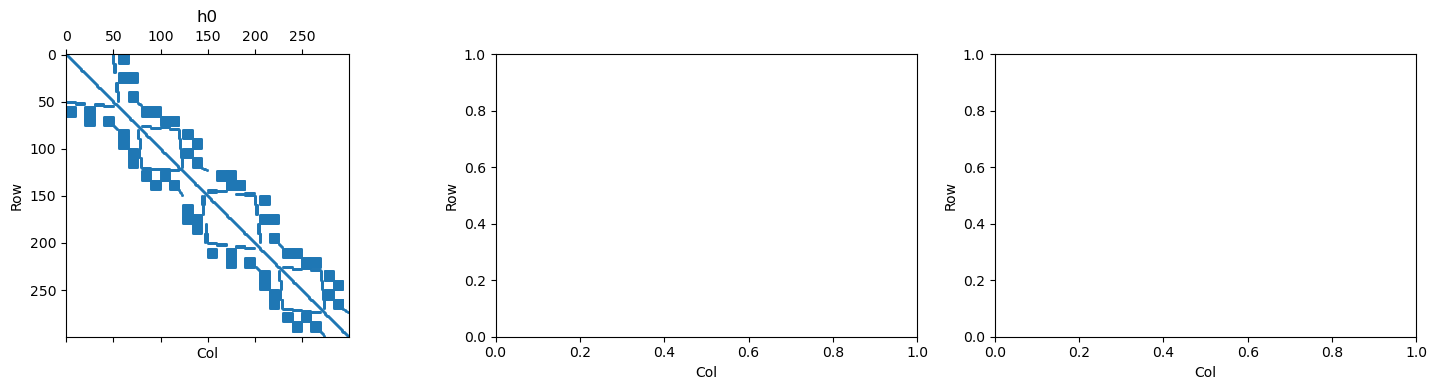

In [12]:

Orbitals.orbital_sets = {"Si": "SiliconSP3D5S", "H": "HydrogenS"}
# Parametric nanowire generator parameters
a_si = 5.50
hamiltonian = Hamiltonian(nx=2, ny=1, nz=1, a=a_si, periodic_dirs='x', passivate_x=False, nn_distance=2.4, transport_dir=[1,0,0], sort_axis='transport')
hamiltonian.initialize()

# h0 is already the principal layer onsite from determine_leads
print(hamiltonian.h_matrix.shape)
# Visualize sparsity patterns
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].spy(hamiltonian.h_matrix, markersize=1); axs[0].set_title('h0')
# axs[1].spy(hl, markersize=1); axs[1].set_title('hl (right->left)')
# axs[2].spy(hr, markersize=1); axs[2].set_title('hr (left->right)')
for ax in axs:
    ax.set_xlabel('Col'); ax.set_ylabel('Row')
plt.tight_layout(); plt.show()

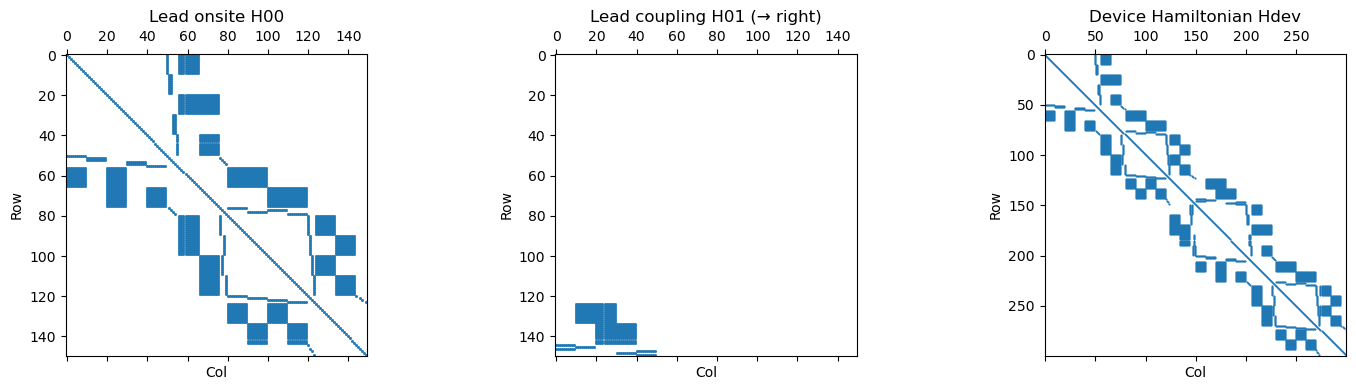

In [13]:
# Build lead principal-layer blocks
ham_new, hL0, hLC, hR0, hRC = hamiltonian.determine_leads(tol=1e-3, choose='center', rewrite_h=False)

# For NEGF, use the device-only Hamiltonian; self-energies are added to its boundary DOFs
Hdev = hamiltonian.h_matrix

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].spy(hL0, markersize=1); axs[0].set_title('Lead onsite H00')
axs[1].spy(hLC, markersize=1); axs[1].set_title('Lead coupling H01 (→ right)')
axs[2].spy(Hdev, markersize=0.5); axs[2].set_title('Device Hamiltonian Hdev')
for ax in axs:
    ax.set_xlabel('Col'); ax.set_ylabel('Row')
plt.tight_layout(); plt.show()

In [14]:
hamiltonian_ = Hamiltonian(nx=2, ny=1, nz=1, a=a_si, periodic_dirs='x', passivate_x=True, nn_distance=2.4, transport_dir=[1,0,0], sort_axis='transport')
hamiltonian_.initialize()
evals = np.linalg.eigvals(hamiltonian_.h_matrix)
for i in np.sort(np.real(evals)):
    print(i)

-11.00360430369466
-10.49914491533055
-10.036565525564182
-10.033533530397674
-9.84087798564559
-9.606019694104122
-9.239301281033795
-8.871547054241187
-8.587079115180776
-8.586976660784636
-8.506624730319485
-8.452480543263649
-8.435996193730421
-7.930701859304758
-7.390846723473064
-7.010472175875546
-7.010042563801729
-6.604169036539399
-6.551788031227691
-6.30558721841244
-6.2855210749500525
-5.546420859256038
-5.4618750820125275
-5.141994545327698
-4.679250144145153
-4.1034530529660875
-3.6921326373769756
-3.6697971824433924
-3.634379678802961
-3.5955132135868277
-3.5581819200254072
-3.4343723405004236
-3.37545441281775
-3.333459242650375
-3.2771025742669257
-3.251943782773951
-3.206062614918266
-3.1668325766203385
-2.8351127161306757
-2.7720895621962867
-2.7681697821953812
-2.7361408686926367
-2.6701936215701307
-2.6268922649087023
-2.5628036868313653
-2.547513757596486
-2.4796382299071538
-2.4034678376415064
-2.3094292079074545
-2.165594565436643
-2.165464349955654
-2.011478630

In [15]:
def _sancho_rubio_surface_gf(E, H00, H01, S00=None, iter_max=200, TOL=1e-12):
    """
    Jiezi surface_gf algorithm translated to use numpy arrays.
    Returns surface Green's function G00 for a semi-infinite lead with onsite H00 and coupling H01 (to the right neighbor).
    """
    E = E + 1e-3j
    n = H00.shape[0]
    I = np.eye(n, dtype=complex)
    S00 = I if S00 is None else S00
    # Convert to dense if needed
    if hasattr(H00, 'toarray'): H00 = H00.toarray()
    if hasattr(H01, 'toarray'): H01 = H01.toarray()
    if hasattr(S00, 'toarray'): S00 = S00.toarray()

    iter_c = 0
    H10 = H01.conj().T
    alpha = H10.copy()   # coupling to the left
    beta  = H01.copy()   # coupling to the right
    epsilon = H00.copy()
    epsilon_s = H00.copy()
    Eeye = I * E

    while iter_c < iter_max:
        iter_c += 1
        inv_term = np.linalg.solve(Eeye - epsilon, I)
        alpha_new = alpha @ inv_term @ alpha
        beta_new  = beta  @ inv_term @ beta
        epsilon_new   = epsilon   + alpha @ inv_term @ beta + beta @ inv_term @ alpha
        epsilon_s_new = epsilon_s + alpha @ inv_term @ beta
        if np.linalg.norm(alpha_new, ord='fro') < TOL and np.linalg.norm(beta_new, ord='fro') < TOL:
            G00 = np.linalg.solve(Eeye - epsilon_s_new, I)
            break
        alpha, beta = alpha_new, beta_new
        epsilon, epsilon_s = epsilon_new, epsilon_s_new
    else:
        print(f"Warning: Surface GF did not converge after {iter_max} iterations")
        G00 = np.linalg.solve(Eeye - epsilon_s, I)
    return G00

||H00_L - H00_R||_max ~ 0?  0.0
||H01_L - H01_R||_max ~ 0?  0.0


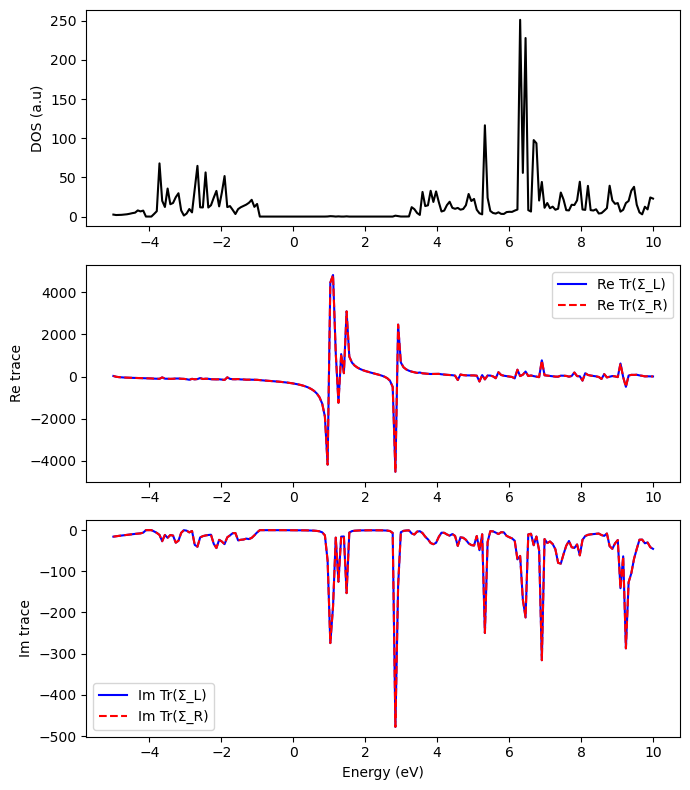

In [16]:
energy = np.linspace(-5, 10, 200)
damp = 0.00001j
tr = np.zeros(energy.shape)
dos = np.zeros(energy.shape)
traces_L = []
traces_R = []

# Use identical principal-layer lead definition on both sides (orientation to the right)
H00 = hL0
H01 = hLC
# For embedding, use device-lead coupling T; in a uniform setup we can take T = H01
T_L = H01
T_R = H01

# Quick sanity checks
print('||H00_L - H00_R||_max ~ 0? ', np.max(np.abs(H00 - H00)))
print('||H01_L - H01_R||_max ~ 0? ', np.max(np.abs(H01 - H01)))

for j, E in enumerate(energy):
    # Surface GFs per side (identical leads)
    G00_L = _sancho_rubio_surface_gf(E, H00, H01)
    G00_R = _sancho_rubio_surface_gf(E, H00, H01)

    # Self-energies Σ = T^† G00 T for left and right
    L = T_L.conj().T @ G00_L @ T_L
    R = T_R.conj().T @ G00_R @ T_R

    traces_L.append(np.trace(L))
    traces_R.append(np.trace(R))

    # Embed Σ into the extended Hamiltonian corners for now (full-system solve)
    L_ = np.zeros_like(ham_new); m = L.shape[0]; L_[:m, :m] = L
    R_ = np.zeros_like(ham_new); R_[-m:, -m:] = R

    A = (E + 1e-9j) * np.eye(ham_new.shape[0], dtype=complex) - (ham_new + L_ + R_)
    Gr = np.linalg.solve(A, np.eye(ham_new.shape[0], dtype=complex))
    dos[j] = -1 / np.pi * np.imag(np.trace(Gr))

fig, ax = plt.subplots(3, 1, figsize=(7,8), sharex=False)
ax[0].plot(energy, dos, 'k')
ax[0].set_ylabel(r'DOS (a.u)')
ax[1].plot(energy, np.real(traces_L), 'b', label='Re Tr(Σ_L)')
ax[1].plot(energy, np.real(traces_R), 'r--', label='Re Tr(Σ_R)')
ax[1].legend(loc='best'); ax[1].set_ylabel('Re trace')
ax[2].plot(energy, np.imag(traces_L), 'b', label='Im Tr(Σ_L)')
ax[2].plot(energy, np.imag(traces_R), 'r--', label='Im Tr(Σ_R)')
ax[2].legend(loc='best'); ax[2].set_ylabel('Im trace')
ax[2].set_xlabel(r'Energy (eV)')
fig.tight_layout(); plt.show()

In [17]:
E = 2
G00 = _sancho_rubio_surface_gf(E, hL0, hRC)
L= hLC @ G00 @ hRC
G00 = _sancho_rubio_surface_gf(E, hR0, hRC)
R =  hRC @ G00 @ hLC
print(np.trace(R))
L_ = np.zeros_like(ham_new)
size = L.shape[0]
L_[:size, :size] = L

R_ = np.zeros_like(ham_new)
size = L.shape[0]
R_[-size:, -size:] = R
# # Recursive GF on the device only, with self-energies added to the first/last diagonal blocks
# g_trans, grd, grl, gru, gr_left = recursive_gf(E, [hl_lead], [h0 + L + R], [hr_lead], damp=damp)
A = (E + 1e-9j) * np.eye(ham_new.shape[0], dtype=complex) - (ham_new + L_ + R_)

(-23.010225901660228-0.24761319617532196j)


In [18]:
# Diagnostics: verify left/right lead definitions are identical
print('Lead onsite Hermitian? ', np.allclose(hL0, hL0.conj().T, atol=1e-10))
print('Right onsite Hermitian? ', np.allclose(hR0, hR0.conj().T, atol=1e-10))
print('||hL0 - hR0||_max =', float(np.max(np.abs(hL0 - hR0))))
print('||hLC - hRC.conj().T||_max =', float(np.max(np.abs(hLC - hRC.conj().T))))
E0 = 1.2
G00_ref = _sancho_rubio_surface_gf(E0, hL0, hLC)
Sigma_ref = hLC.conj().T @ G00_ref @ hLC
G00_L = _sancho_rubio_surface_gf(E0, hL0, hLC)
G00_R = _sancho_rubio_surface_gf(E0, hR0, hLC)
Sigma_L = hLC.conj().T @ G00_L @ hLC
Sigma_R = hLC.conj().T @ G00_R @ hLC
print('Test E0 =', E0)
print('||Sigma_ref - Sigma_L||_max =', float(np.max(np.abs(Sigma_ref - Sigma_L))))
print('||Sigma_L - Sigma_R||_max =', float(np.max(np.abs(Sigma_L - Sigma_R))))
print('trace(Sigma_L)=', complex(np.trace(Sigma_L)))
print('trace(Sigma_R)=', complex(np.trace(Sigma_R)))

Lead onsite Hermitian?  True
Right onsite Hermitian?  True
||hL0 - hR0||_max = 0.0
||hLC - hRC.conj().T||_max = 0.0
Test E0 = 1.2
||Sigma_ref - Sigma_L||_max = 0.0
||Sigma_L - Sigma_R||_max = 0.0
trace(Sigma_L)= (787.6488897667341-17.301511916094153j)
trace(Sigma_R)= (787.6488897667341-17.301511916094153j)


Periodic lead H00 Hermitian?  True
Interface conjugacy near-zero?  True


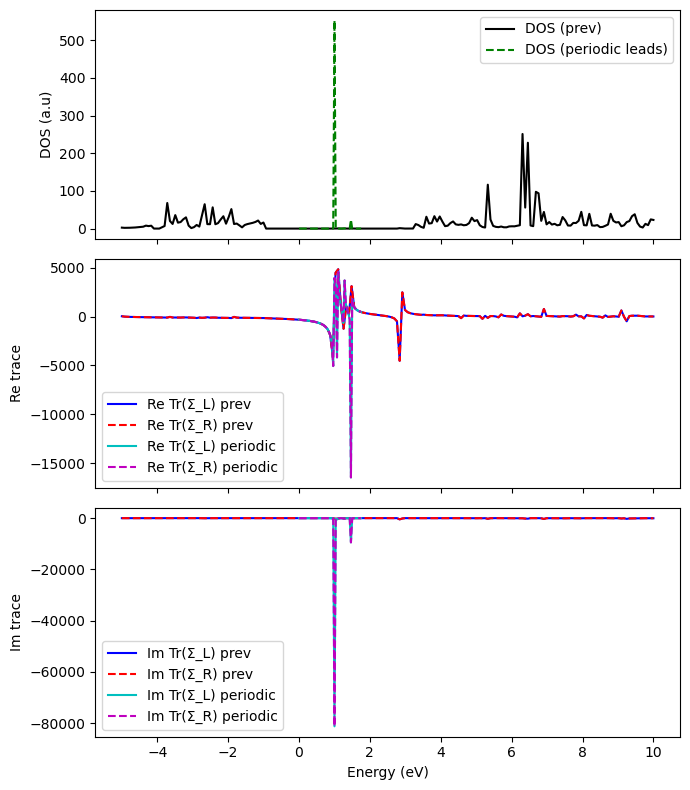

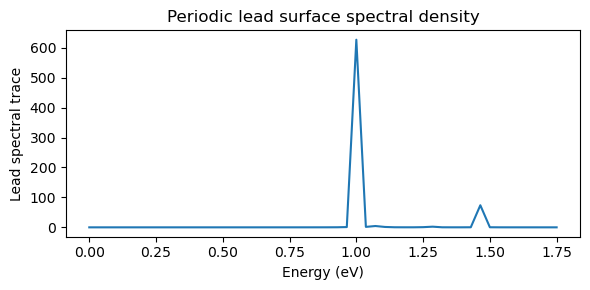

In [19]:
# Build periodic-in-x lead blocks (H00, H01) from a separate 2-cell supercell
# Keep the device region (current hamiltonian) open in x; only the leads are periodic.

# 1) Construct a periodic-in-x nanowire used only to define leads
Orbitals.orbital_sets = {"Si": "SiliconSP3D5S", "H": "HydrogenS"}
a_si = 5.50
lead_builder = Hamiltonian(nx=2, ny=1, nz=1, a=a_si,
                           periodic_dirs='x', passivate_x=False,  # periodic in x removes surface along transport
                           nn_distance=2.4, transport_dir=[1,0,0], sort_axis='transport')
lead_builder.initialize()
Hlead = lead_builder.h_matrix

# 2) Extract principal-layer onsite/coupling blocks from the periodic supercell
m = Hlead.shape[0] // 2
H00_p = Hlead[:m, :m]
H01_p = Hlead[:m, m:2*m]

# Sanity: Hermiticity and expected conjugacy
print('Periodic lead H00 Hermitian? ', np.allclose(H00_p, H00_p.conj().T, atol=1e-10))
print('Interface conjugacy near-zero? ', np.max(np.abs(H01_p.conj().T - Hlead[m:2*m, :m])) < 1e-10)

# 3) Recompute self-energies with periodic leads and embed into existing extended Hamiltonian ham_new
energy_p = np.linspace(0, 1.75, 50)
traces_L_p, traces_R_p, dos_p = [], [], []

for E in energy_p:
    G00_Lp = _sancho_rubio_surface_gf(E, H00_p, H01_p)
    G00_Rp = _sancho_rubio_surface_gf(E, H00_p, H01_p)
    Sigma_Lp = H01_p.conj().T @ G00_Lp @ H01_p
    Sigma_Rp = H01_p.conj().T @ G00_Rp @ H01_p

    traces_L_p.append(np.trace(Sigma_Lp))
    traces_R_p.append(np.trace(Sigma_Rp))

    # Embed into corners of ham_new
    Lp_ = np.zeros_like(ham_new); m0 = Sigma_Lp.shape[0]; Lp_[:m0, :m0] = Sigma_Lp
    Rp_ = np.zeros_like(ham_new); Rp_[-m0:, -m0:] = Sigma_Rp

    A = (E + 1e-9j) * np.eye(ham_new.shape[0], dtype=complex) - (ham_new + Lp_ + Rp_)
    Gr = np.linalg.solve(A, np.eye(ham_new.shape[0], dtype=complex))
    dos_p.append(-1/np.pi * np.imag(np.trace(Gr)))

traces_L_p = np.array(traces_L_p)
traces_R_p = np.array(traces_R_p)
dos_p = np.array(dos_p)

# 4) Plot: compare previous vs periodic-lead results
fig, ax = plt.subplots(3, 1, figsize=(7,8), sharex=True)
ax[0].plot(energy, dos, 'k', label='DOS (prev)')
ax[0].plot(energy_p, dos_p, 'g--', label='DOS (periodic leads)')
ax[0].legend(loc='best'); ax[0].set_ylabel('DOS (a.u)')

ax[1].plot(energy, np.real(traces_L), 'b', label='Re Tr(Σ_L) prev')
ax[1].plot(energy, np.real(traces_R), 'r--', label='Re Tr(Σ_R) prev')
ax[1].plot(energy_p, np.real(traces_L_p), 'c', label='Re Tr(Σ_L) periodic')
ax[1].plot(energy_p, np.real(traces_R_p), 'm--', label='Re Tr(Σ_R) periodic')
ax[1].legend(loc='best'); ax[1].set_ylabel('Re trace')

ax[2].plot(energy, np.imag(traces_L), 'b', label='Im Tr(Σ_L) prev')
ax[2].plot(energy, np.imag(traces_R), 'r--', label='Im Tr(Σ_R) prev')
ax[2].plot(energy_p, np.imag(traces_L_p), 'c', label='Im Tr(Σ_L) periodic')
ax[2].plot(energy_p, np.imag(traces_R_p), 'm--', label='Im Tr(Σ_R) periodic')
ax[2].legend(loc='best'); ax[2].set_ylabel('Im trace')
ax[2].set_xlabel('Energy (eV)')
fig.tight_layout(); plt.show()

# 5) Lead spectral function check (should be ~0 in the gap for periodic leads)
A_lead = [-np.imag(np.trace(_sancho_rubio_surface_gf(E, H00_p, H01_p)))/np.pi for E in energy_p]
plt.figure(figsize=(6,3))
plt.plot(energy_p, A_lead)
plt.ylabel('Lead spectral trace')
plt.xlabel('Energy (eV)')
plt.title('Periodic lead surface spectral density')
plt.tight_layout(); plt.show()

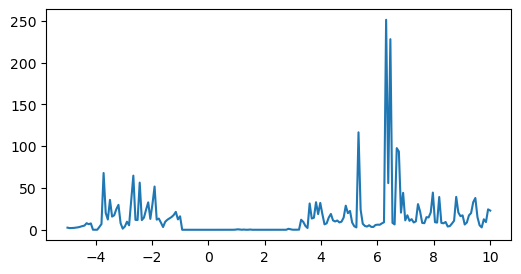

In [23]:
plt.figure(figsize=(6,3))
plt.plot(energy, dos)